In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import datetime

%matplotlib inline

|              	|                                      Данные                                     	|
|:------------:	|:-------------------------------------------------------------------------------:	|
| Date         	| Плановая дата доставки до клиента                                               	|
| DateOrder    	| Дата оформления заказа                                                          	|
| ClientID     	| ID клиента                                                                      	|
| ChannelID    	| ID канала сбыта                                                                 	|
| OrderID      	| ID заказа, присваиваемый сайтом                                                 	|
| MaterialID   	| ID материала                                                                    	|
| DeliveryType 	| Тип доставки                                                                    	|
| Cluster      	| Кластер доставки                                                                	|
| Interval     	| Временной интервал доставки (с/до)                                              	|
| CancelFlag   	| Метка отмены заказов(целевая переменная для первого этапа)                      	|
| OrderCnt     	| Количество заказанных предметов                                                 	|
| Prepay       	| Признак предоплаты                                                              	|
| Count_edit   	| Число редактирований заказа клиентом, значение "1" означает первоначальный ввод 	|
| GroupId   	| Группа Закупок ID 	|

In [ ]:
data = pd.read_csv('train.csv', encoding='cp1251', low_memory=False)
data.head()

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
0,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328810.0,61.0,NaN,0,1.0,Обычная доставка,0,1
1,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3281258.0,30.0,NaN,0,2.0,Обычная доставка,0,1
2,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3210734.0,10.0,NaN,0,1.0,Обычная доставка,0,1
3,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328848.0,61.0,NaN,0,2.0,Обычная доставка,0,1
4,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347801.0,17.0,NaN,0,10.0,Обычная доставка,0,1


Заметим, что данные сильно несбалансированны: кол-во неотмененных заказов гораздо больше чем отмененных

In [ ]:
data.value_counts('CancelFlag')

CancelFlag
0    8519074
1     504110
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9023184 entries, 0 to 9023183
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Interval      object 
 1   Date          object 
 2   OrderDate     object 
 3   ClientID      int64  
 4   ChannelID     int64  
 5   OrderID       int64  
 6   MaterialID    float64
 7   GroupID       float64
 8   Cluster       object 
 9   CancelFlag    int64  
 10  OrderCnt      float64
 11  DeliveryType  object 
 12  prepay        int64  
 13  count_edit    int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 963.8+ MB


Так как в нашем датасете, данных очень много (более 9 млн. записей), можем удалить часть данных, чтобы сбалансировать выборку

In [ ]:
data_CancelFlag0 = data[data['CancelFlag']==0].sample(504110)

In [ ]:
# data_2 = pd.read_csv('cut_train.csv', encoding='cp1251', low_memory=False, index_col=0)

In [ ]:
# data_2.to_csv('cut_train.csv')

In [2]:
# balanced_data = pd.read_csv('Documents/balanced_utkonos.csv')
# balanced_data.index = balanced_data['Unnamed: 0'].values
# balanced_data = balanced_data.drop('Unnamed: 0', axis=1)

C:\Users\Veronika\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
balanced_data = pd.concat([data[data.CancelFlag==1], data_CancelFlag0])

In [23]:
balanced_data.value_counts('CancelFlag')

CancelFlag
1    504110
0    504110
dtype: int64

### **Пропущенные значения**

In [24]:
balanced_data.isnull().any()

Interval        False
Date            False
OrderDate       False
ClientID        False
ChannelID       False
OrderID         False
MaterialID       True
GroupID          True
Cluster          True
CancelFlag      False
OrderCnt         True
DeliveryType    False
prepay          False
count_edit      False
dtype: bool

In [ ]:
# balanced_data['Cluster'] = balanced_data['Cluster'].fillna('0')

In [3]:
balanced_data = balanced_data.dropna()

### **Обработаем данные**

In [4]:
tmp = balanced_data['Interval'].str.split('-')
balanced_data['interval_low']=tmp.apply(lambda x: int(x[0]))
balanced_data['interval_high']=tmp.apply(lambda x: int(x[1][:-1]))
del balanced_data['Interval']

Находим середину интервала, чтобы определить в какое время суток была произведена доставка

In [5]:
balanced_data['interval_avg'] = (balanced_data['interval_high'] + balanced_data['interval_low']) / 2

Здесь мы обозначаем в каком временном интервале находится определенное время дня Утро - с 6 по 12 День - с 12 по 18 Вечер - с 18 по 24 Ночь - с 24 по 6

In [6]:
morning = list(range(6, 12))
day = list(range(12, 18))
evening = list(range(18, 24))
night = [24] + list(range(1, 6))

In [7]:
morning = balanced_data['interval_avg'].isin(morning)
day = balanced_data['interval_avg'].isin(day)
evening = balanced_data['interval_avg'].isin(evening)
night = balanced_data['interval_avg'].isin(night)

Определяем до скольких дней длился заказ до доставки или до момента отказа

In [8]:
balanced_data['morning'] = morning.apply(lambda x: 1 if x else 0)
balanced_data['day'] = day.apply(lambda x: 1 if x else 0)
balanced_data['evening'] = evening.apply(lambda x: 1 if x else 0)
balanced_data['night'] = night.apply(lambda x: 1 if x else 0)

In [9]:
orderDate = balanced_data.OrderDate.apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
date = balanced_data.Date.apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
balanced_data['delta_day'] = (date-orderDate).dt.days.astype(int).values

In [10]:
balanced_data.head()

,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,...,prepay,count_edit,interval_low,interval_high,interval_avg,morning,day,evening,night,delta_day
5592938,21/08/2018,20/08/2018,94156316,2,98356030220,3279174.0,24.0,HUB5,1,1.0,...,0,1,12,14,13.0,0,1,0,0,1
5592939,21/08/2018,20/08/2018,94156316,2,98356030220,3289067.0,35.0,HUB5,1,1.0,...,0,1,12,14,13.0,0,1,0,0,1
5592940,21/08/2018,20/08/2018,94156316,2,98356030220,3139357.0,15.0,HUB5,1,2.0,...,0,1,12,14,13.0,0,1,0,0,1
5592941,21/08/2018,20/08/2018,94156316,2,98356030220,3141193.0,34.0,HUB5,1,1.0,...,0,1,12,14,13.0,0,1,0,0,1
5592942,21/08/2018,20/08/2018,94156316,2,98356030220,3296900.0,32.0,HUB5,1,1.0,...,0,1,12,14,13.0,0,1,0,0,1


Уменьшаем количество изменений заказа, так как 1 означает только первоначальный ввод без изменений

In [11]:
balanced_data['count_edit'] -= 1

Производим замену типа доставки на более удобный для обработки вид. Обычную доставку будет обозначать 0, а доставку день в день - 1

In [12]:
balanced_data['DeliveryType'] = balanced_data['DeliveryType'].map({'Обычная доставка': 0, 'Доставка День в День': 1})

In [13]:
balanced_data.head()

,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,...,prepay,count_edit,interval_low,interval_high,interval_avg,morning,day,evening,night,delta_day
5592938,21/08/2018,20/08/2018,94156316,2,98356030220,3279174.0,24.0,HUB5,1,1.0,...,0,0,12,14,13.0,0,1,0,0,1
5592939,21/08/2018,20/08/2018,94156316,2,98356030220,3289067.0,35.0,HUB5,1,1.0,...,0,0,12,14,13.0,0,1,0,0,1
5592940,21/08/2018,20/08/2018,94156316,2,98356030220,3139357.0,15.0,HUB5,1,2.0,...,0,0,12,14,13.0,0,1,0,0,1
5592941,21/08/2018,20/08/2018,94156316,2,98356030220,3141193.0,34.0,HUB5,1,1.0,...,0,0,12,14,13.0,0,1,0,0,1
5592942,21/08/2018,20/08/2018,94156316,2,98356030220,3296900.0,32.0,HUB5,1,1.0,...,0,0,12,14,13.0,0,1,0,0,1


Удаляем ненужные данные: в нашем случае это ID клиента, потому что эта информация не влияет на нахождение закономерности отказа от заказа

In [13]:
balanced_data = balanced_data.drop(['ClientID'], axis=1)

Удаляем даты, так как точная дата заказа не влияет на закономерность

In [14]:
del balanced_data['Date']
del balanced_data['OrderDate']

In [16]:
balanced_data.head()

,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit,interval_low,interval_high,interval_avg,morning,day,evening,night,delta_day
5592938,2,98356030220,3279174.0,24.0,HUB5,1,1.0,0,0,0,12,14,13.0,0,1,0,0,1
5592939,2,98356030220,3289067.0,35.0,HUB5,1,1.0,0,0,0,12,14,13.0,0,1,0,0,1
5592940,2,98356030220,3139357.0,15.0,HUB5,1,2.0,0,0,0,12,14,13.0,0,1,0,0,1
5592941,2,98356030220,3141193.0,34.0,HUB5,1,1.0,0,0,0,12,14,13.0,0,1,0,0,1
5592942,2,98356030220,3296900.0,32.0,HUB5,1,1.0,0,0,0,12,14,13.0,0,1,0,0,1


In [17]:
balanced_data.dtypes

ChannelID          int64
OrderID            int64
MaterialID       float64
GroupID          float64
Cluster           object
CancelFlag         int64
OrderCnt         float64
DeliveryType       int64
prepay             int64
count_edit         int64
interval_low       int64
interval_high      int64
interval_avg     float64
morning            int64
day                int64
evening            int64
night              int64
delta_day          int32
dtype: object

In [108]:
balanced_data.value_counts('Cluster')

Cluster
HUB5     200770
HUB17     15844
HUB19     14640
HUB6      14172
HUB1      12834
HUB9      10491
HUB20      9750
HUB16      9334
HUB22      9221
HUB7       8722
HUB8       7982
HUB2       7167
HUB14      6536
HUB21      5388
HUB4       4996
HUB11      4742
ZON1       4667
HUB10      4063
HUB18      4034
HUB13      4033
HUB3       3929
HUB12      3695
HUB15      3559
dtype: int64

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
balanced_data['Cluster'] = le.fit_transform(balanced_data['Cluster'])

In [19]:
balanced_data.value_counts('Cluster')

Cluster
17    200770
8      15844
10     14640
18     14172
0      12834
21     10491
12      9750
7       9334
14      9221
19      8722
20      7982
11      7167
5       6536
13      5388
16      4996
2       4742
22      4667
1       4063
9       4034
4       4033
15      3929
3       3695
6       3559
dtype: int64

In [16]:
cancel_data = balanced_data[['CancelFlag', 'morning',	'day', 'evening',	'night']].groupby('CancelFlag').sum()
print(cancel_data)
size1 = cancel_data.values[1]
size2 = cancel_data.values[0]
proportion=size1/(size1+size2)

print(proportion)

            morning    day  evening  night
CancelFlag                                
0             71787  64677    46942    883
1             66319  64299    44526   1678
[0.48020361 0.49853461 0.4867932  0.65521281]


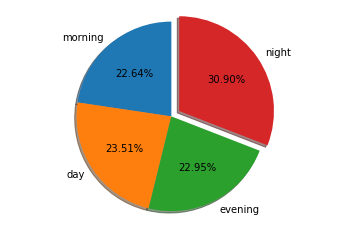

In [41]:
labels = 'morning',	'day', 'evening',	'night'
explode = (0, 0, 0, 0.1) 
fig1, ax1 = plt.subplots()

ax1.pie(proportion*100, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

Как можем заметить по построенной диаграмме - ночь более значительно влияет на отмену заказа

prepay
0    316663
1     53906
Name: CancelFlag, dtype: int64


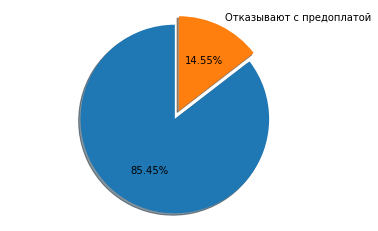

In [42]:
cancel_data = balanced_data[['CancelFlag', 'prepay']].groupby('prepay').count()['CancelFlag']
print(cancel_data)

labels = '', 'Отказывают с предоплатой'
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(cancel_data, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

Можем заметить, что люди с предоплатой гораздо реже отказываются

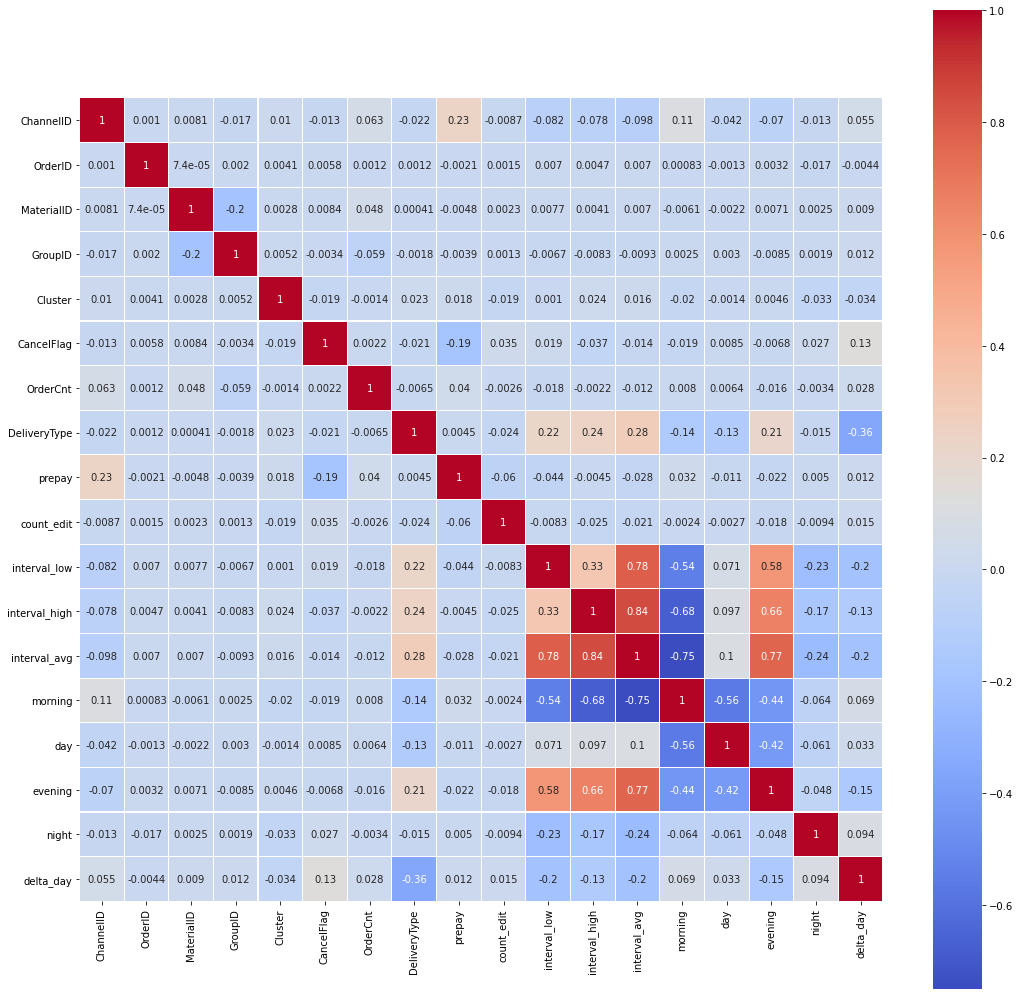

In [29]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(balanced_data.corr(), annot=True, linewidths=.1, cmap="coolwarm", square=True)

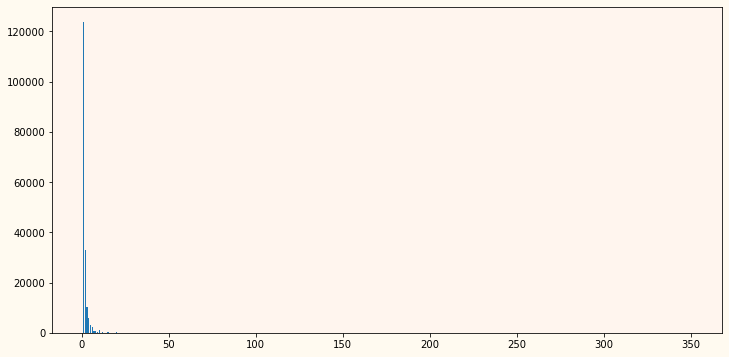

In [43]:
fig, ax = plt.subplots()
s = balanced_data.groupby('OrderCnt').sum()['CancelFlag']
ax.bar(s.index, s.values)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

Чем меньше количество заказанных предметов, тем больше отказов

### **Отбор признаков**

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = balanced_data.drop('CancelFlag', axis=1)
y = balanced_data.CancelFlag.astype(int)

In [18]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)

X_best_col = X.columns[selector.get_support(indices=True)]
X_best_col

Index(['Cluster', 'DeliveryType', 'prepay', 'count_edit', 'interval_low',
       'interval_high', 'interval_avg', 'morning', 'night', 'delta_day'],
      dtype='object')

Так как данные категориальные, воспользуемся критерием `f-value`, отберем 10 признаков:

`Cluster`, `DeliveryType`, `prepay`, `count_edit`, `interval_low`, `interval_high`, `interval_avg`, `morning`, `night`, `delta_day`

### **Стандартизируем данные**

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [47]:
X_train.shape, X_test.shape

((185284, 17), (185285, 17))

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
scaler.fit(X_train[X_best_col])

X_train_scaled_best = scaler.transform(X_train[X_best_col])
X_test_scaled_best = scaler.transform(X_test[X_best_col])

### **Построение моделей**

Метод отрисовки `Roc кривой`

In [22]:
def show_roc_auc(model, X_test, y_test, name):
  pred_proba = model.predict_proba(X_test)
  fpr, tpr, thresholds = roc_curve(y_test,pred_proba[:,1])
  print(roc_auc_score(y_test,pred_proba[:,1]))
  plt.plot(fpr,tpr)
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])

  plt.title(name)
  plt.xlabel("False Positive")
  plt.ylabel("True Positive")

  plt.grid(True)
  plt.show()

#### **Метод K ближайших соседей**

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [51]:
y_pred_knn = knn.predict(X_test_scaled)

In [52]:
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[57221 36759]
 [34256 57049]]
              precision    recall  f1-score   support

           0       0.63      0.61      0.62     93980
           1       0.61      0.62      0.62     91305

    accuracy                           0.62    185285
   macro avg       0.62      0.62      0.62    185285
weighted avg       0.62      0.62      0.62    185285



In [69]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_knn))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_knn))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)))

Mean Absolute Error: 0.38327441509026633
Mean Squared Error: 0.38327441509026633
Root Mean Squared Error: 0.6190916047648088


0.66546951075523


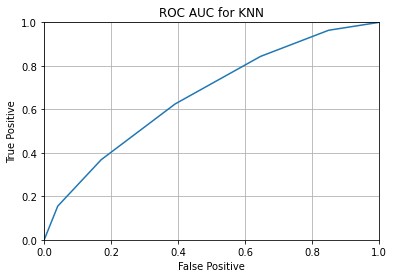

In [89]:
show_roc_auc(knn, X_test_scaled, y_test, "ROC AUC for KNN")



---

---





In [53]:
knn_best = KNeighborsClassifier(n_neighbors=5)
knn_best.fit(X_train_scaled_best, y_train)

KNeighborsClassifier()

In [55]:
y_pred_knn_best = knn_best.predict(X_test_scaled_best)

In [56]:
print(confusion_matrix(y_test, y_pred_knn_best))
print(classification_report(y_test, y_pred_knn_best))

[[60109 33871]
 [37876 53429]]
              precision    recall  f1-score   support

           0       0.61      0.64      0.63     93980
           1       0.61      0.59      0.60     91305

    accuracy                           0.61    185285
   macro avg       0.61      0.61      0.61    185285
weighted avg       0.61      0.61      0.61    185285



In [70]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_knn_best))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_knn_best))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn_best)))

Mean Absolute Error: 0.38722508567881914
Mean Squared Error: 0.38722508567881914
Root Mean Squared Error: 0.6222741242240586


0.6689174632345893


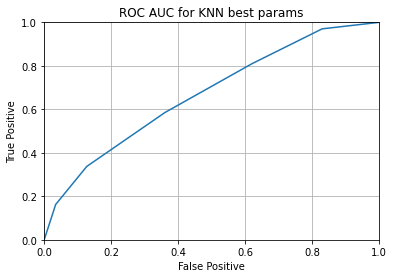

In [90]:
show_roc_auc(knn_best, X_test_scaled_best, y_test, "ROC AUC for KNN best params")



---

---





In [207]:
error = []

for i in range(1, 40):
    knn1 = KNeighborsClassifier(n_neighbors=i,)
    knn1.fit(X_train_scaled_best[:10000], y_train[:10000])
    pred_i = knn1.predict(X_test_scaled_best)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

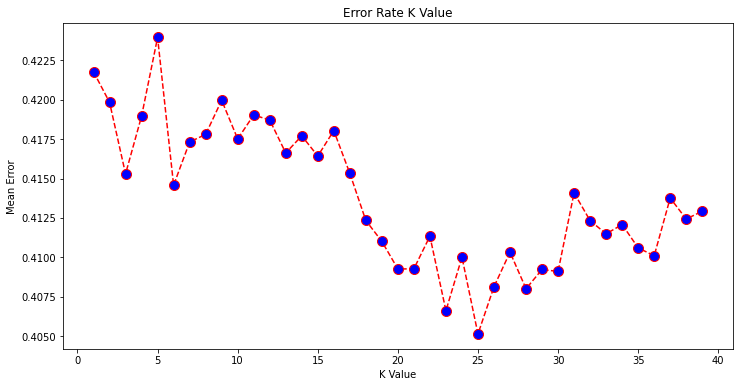

In [209]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')



---

---





In [57]:
knn_params = KNeighborsClassifier(n_neighbors=25)
knn_params.fit(X_train_scaled_best, y_train)

KNeighborsClassifier(n_neighbors=25)

In [58]:
y_pred_knn_p = knn_params.predict(X_test_scaled_best)

In [59]:
print(confusion_matrix(y_test, y_pred_knn_p))
print(classification_report(y_test, y_pred_knn_p))

[[62704 31276]
 [38579 52726]]
              precision    recall  f1-score   support

           0       0.62      0.67      0.64     93980
           1       0.63      0.58      0.60     91305

    accuracy                           0.62    185285
   macro avg       0.62      0.62      0.62    185285
weighted avg       0.62      0.62      0.62    185285



In [71]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_knn_p))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_knn_p))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn_p)))

Mean Absolute Error: 0.37701378956742315
Mean Squared Error: 0.37701378956742315
Root Mean Squared Error: 0.6140144864475293


0.6858737015947814


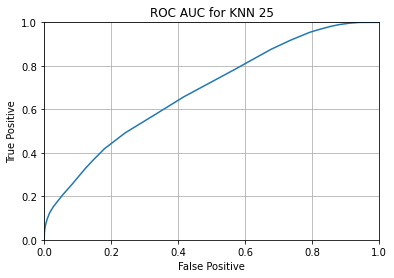

In [91]:
show_roc_auc(knn_params, X_test_scaled_best, y_test, "ROC AUC for KNN 25")

#### **Дерево решений**

In [61]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train_scaled_best, y_train)

DecisionTreeClassifier()

In [62]:
y_pred_tree = tree.predict(X_test_scaled_best)

In [68]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_tree))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_tree))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_tree)))

Mean Absolute Error: 0.34761043797393204
Mean Squared Error: 0.34761043797393204
Root Mean Squared Error: 0.5895849709532394


In [63]:
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[70828 23152]
 [41255 50050]]
              precision    recall  f1-score   support

           0       0.63      0.75      0.69     93980
           1       0.68      0.55      0.61     91305

    accuracy                           0.65    185285
   macro avg       0.66      0.65      0.65    185285
weighted avg       0.66      0.65      0.65    185285



0.7321791265192461


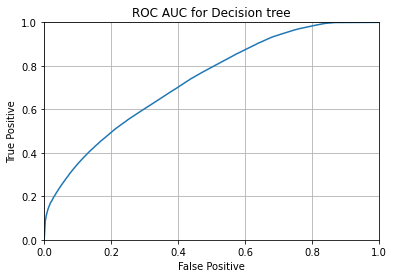

In [95]:
show_roc_auc(tree, X_test_scaled_best, y_test, "ROC AUC for Decision tree")

In [28]:
from sklearn.tree import DecisionTreeClassifier

tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
tree_gridsearch = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)
tree_gridsearch.fit(X_train_scaled_best, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

0.7334043575263213


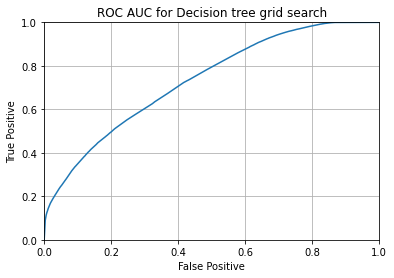

In [29]:
show_roc_auc(tree_gridsearch, X_test_scaled_best, y_test, "ROC AUC for Decision tree grid search")

In [ ]:
tree_gridsearch.best_params_

#### **Случайный лес**

In [64]:
from sklearn.ensemble import RandomForestRegressor

rand_for_reg = RandomForestRegressor(n_estimators=20, random_state=0)
rand_for_reg.fit(X_train_scaled_best, y_train)
y_pred_rand_for_reg = rand_for_reg.predict(X_test_scaled_best)

In [65]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rand_for_reg))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rand_for_reg))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rand_for_reg)))

Mean Absolute Error: 0.4051562730376338
Mean Squared Error: 0.2038679348445744
Root Mean Squared Error: 0.4515173693719594


#### **Линейный дискриминантный анализ**

In [77]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled_best, y_train)
X_test_lda = lda.transform(X_test_scaled_best)

In [78]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(max_depth=2, random_state=0)

rand_forest.fit(X_train_lda, y_train)
y_pred_rand_forest = rand_forest.predict(X_test_lda)

In [80]:
print(confusion_matrix(y_test, y_pred_rand_forest))
print(classification_report(y_test, y_pred_rand_forest))

[[81256 12724]
 [64825 26480]]
              precision    recall  f1-score   support

           0       0.56      0.86      0.68     93980
           1       0.68      0.29      0.41     91305

    accuracy                           0.58    185285
   macro avg       0.62      0.58      0.54    185285
weighted avg       0.61      0.58      0.54    185285



In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy ' + str(accuracy_score(y_test, y_pred_rand_forest)))

Accuracy 0.581460992525029


In [82]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rand_forest))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rand_forest))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rand_forest)))

Mean Absolute Error: 0.41853900747497097
Mean Squared Error: 0.41853900747497097
Root Mean Squared Error: 0.6469459076885571


0.6232081954083794


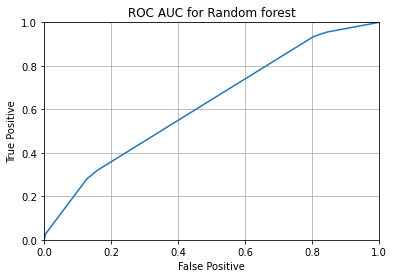

In [98]:
show_roc_auc(rand_forest, X_test_lda, y_test, "ROC AUC for Random forest")

#### **Bagging**

In [83]:
from sklearn.ensemble import BaggingClassifier

b_model = BaggingClassifier()
b_model.fit(X_train_scaled_best,y_train)
y_pred_bag = b_model.predict(X_test_scaled_best)
print(confusion_matrix(y_test,y_pred_bag))
print('test data')
print(accuracy_score(y_test,y_pred_bag))

[[69622 24358]
 [40046 51259]]
test data
0.6524057532989719


0.7319659055329044


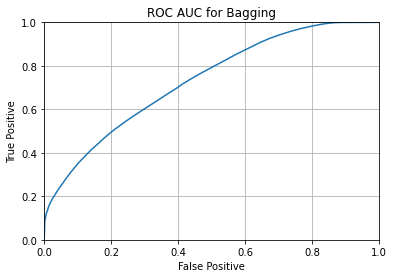

In [88]:
show_roc_auc(b_model, X_test_scaled_best, y_test, "ROC AUC for Bagging")

#### **Вывод:**

Поместим все результаты в таблицу:

| Название классификатора 	|     Результаты     	|
|:-------------:	|:------------------:	|
| **KNeighborsClassifier** 	| 0.66546951075523 	|
| **KNN с наиболее важными признаками** 	| 0.6689174632345893 	|
| **KNN n_neigbors=25**     	| 0.6858737015947814  	|
| **Дерево решений**     	| 0.7321791265192461  	|
| **Случайный лес**     	| 0.6232081954083794	|
| **Bagging**     	|  0.7319659055329044 	|